In [1]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
PATH = "/kaggle/input/digit-recognizer/"

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [3]:
embedding_dims = 2
batch_size = 2
epochs = 240

In [15]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define class MNIST
I'll define `class MNIST` which was inherited `torch.utils.data.Dataset`.

In [3]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:            
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)
        
        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)
            
            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img


In [6]:
train_ds = MNIST(train_df, 
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

NameError: name 'MNIST' is not defined

In [25]:
test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

## Define TripletLoss

In [4]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def predict(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        predictions = distance_positive < distance_negative
        losses = torch.max(distance_positive - distance_negative + self.margin, self.zero_tensor)
        return losses, predictions

    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Neural Network

In [5]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

### weight initialize

In [7]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

### Create Instances
Use JIT compilation for high speed.

In [29]:
model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())

In [8]:
import warnings
import zipfile
from PIL import Image
import os
# CSV variable
all_data_csv = pd.read_csv('../Data/CSV/all_data_info.csv')


warnings.simplefilter(action='ignore', category=FutureWarning)

# if the data frame is not yet defined we can extract it from files if it is already stored there.
# if the data frame is not saved in files either, we will make it from start
if ("train_data_frame" not in globals()) and (not os.path.isfile("../Data/Variables/train_data_frame.pkl")):
    # We will Train our model only with artists with more than 10 paints in the storage
    paints_per_painter = all_data_csv['artist'].value_counts()
    #a =  all_data_csv.items()
    #paints_per_painter = all_data_csv.items()['artist'].value_counts()
    #print(paints_per_painter)
    actual_artist_list = [paints_per_painter.index[i] for i in range(len(paints_per_painter)) if paints_per_painter[i] > 10]

    # Here we are classifying the data by train and test paints as they registered in the CSV file
    # We take only the paints of the artist with more of 10 paints
    train_data_frame = pd.DataFrame({})
    test_data_frame = pd.DataFrame({})
    i1 = 0
    for artist in actual_artist_list:
        i1 += 1
        artist_data = all_data_csv[(all_data_csv['artist']==artist)]
        artist_train_data = artist_data.loc[(artist_data.in_train == True)]
        artist_test_data = artist_data.loc[(artist_data.in_train == False)]
        train_data_frame = pd.concat([train_data_frame, artist_train_data])
        test_data_frame = pd.concat([test_data_frame, artist_test_data])

    train_data_frame.to_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame.to_pickle("../Data/Variables/test_data_frame.pkl")

else:
    train_data_frame = pd.read_pickle("../Data/Variables/train_data_frame.pkl")
    test_data_frame = pd.read_pickle("../Data/Variables/test_data_frame.pkl")


class RootDataSet:
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):

        self.res_size = res_size
        self.train_data_frame = train_data_frame.reset_index(drop=True)
        self.train_zip_name = train_zip_name
        if Fixed_res:
           self.train_zip_path = "../Data/Zips/Fixed_Zips/" + self.train_zip_name + '_' + str(res_size) + ".zip"
           self.train_zip_name+= '/'
        else:
            self.train_zip_path = "../Data/Zips/" + self.train_zip_name + ".zip"

            self.train_zip_name += '/'
        self.make_data_frame()


        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((res_size, res_size))])

        if is_train:
            self.train_images_files = self.data_frame.iloc[:, 11].values
            self.train_labels = self.data_frame.iloc[:, 0].values
            self.train_index = self.data_frame.index.values

        self.choose_n_to_visualization(150)

    def make_data_frame(self):
        self.train_archive = zipfile.ZipFile(self.train_zip_path, 'r')
        image_name_list = []
        for image_name in self.train_archive.namelist():
            image_name_list.append(image_name[len(self.train_zip_name):])
        self.data_frame = train_data_frame.loc[train_data_frame['new_filename'].isin(image_name_list)]
        data_frame_count = self.data_frame["artist"].value_counts()[0:3]
        self.data_frame = self.data_frame[self.data_frame['artist'].isin(data_frame_count[data_frame_count > 15].index) & self.data_frame['artist'].isin(data_frame_count[data_frame_count < 33335].index)][:-1]
        self.data_frame = self.data_frame.reset_index(drop=True)


    def choose_n_to_visualization(self, n):
        indices = np.random.choice(self.train_index, n)
        n_images = torch.empty((0, 3, self.res_size, self.res_size))
        labels = []
        for index in indices:
            file_name = self.train_images_files[index]
            image_data = self.train_archive.open(self.train_zip_name + file_name)
            image = Image.open(image_data)
            label = self.train_labels[index]

            image = self.transform(image)
            if image.shape[0] == 1:
                image = torch.cat([image, image, image], 0)
            if image.shape[0] == 4:
                image = image[0:3]

            n_images = torch.cat([n_images, torch.reshape(image, (1, 3, self.res_size, self.res_size))], 0)
            labels.append(label)
        self.n_images = n_images
        self.labels = labels


# inspiration from https://www.kaggle.com/code/spyrosrigas/20-painters-classification-with-cnns-and-svms
class TripletDataSet(Dataset, RootDataSet):
    def __init__(self, train_zip_name, train_data_frame, Fixed_res=True, res_size=256, is_train = True):
        RootDataSet.__init__(self, train_zip_name, train_data_frame, Fixed_res, res_size, is_train)

    def __len__(self):
        return len(self.data_frame)


    def __getitem__(self, index):
        try:

            # extraction process of the three images per forward sample the 'triplet loss' is relies on
            anchor_file_name = self.train_images_files[index]
            anchor_image_data = self.train_archive.open(self.train_zip_name + anchor_file_name)
            anchor_image = Image.open(anchor_image_data)
            anchor_label = self.train_labels[index]
            #print(f"index: {index} is {anchor_label}")

            bool_list = np.array(self.train_labels[self.train_index!=index]==anchor_label)
            positive_list = np.array(self.train_index[self.train_index!=index])
            positive_list = positive_list[bool_list]

            # case when in sub train group, item don't have a positive partner
            if(len(positive_list) == 0):
                positive_index = index
            else:
                positive_index = random.choice(positive_list)

            positive_file_name = self.train_images_files[positive_index]
            positive_image_data = self.train_archive.open(self.train_zip_name + positive_file_name)
            positive_image = Image.open(positive_image_data)

            negative_list = self.train_index[self.train_index!=index][self.train_labels[self.train_index!=index]!=anchor_label]
            negative_index = random.choice(negative_list)
            negative_file_name = self.train_images_files[negative_index]
            negative_image_data = self.train_archive.open(self.train_zip_name + negative_file_name)
            negative_image = Image.open(negative_image_data)

            if self.train_labels[positive_index] != self.train_labels[index]:
                print("positive and anchor dont have the same label")

            if self.train_labels[negative_index] == self.train_labels[index]:
                print("negative and anchor have the same label")

            #if index == 5:
            #    print(self.train_index[positive_index])
            #    print(self.train_index[negative_index])
            # transform the images to same resolution tensors

            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

            # we will feed the model a 3 channel images.
            if anchor_image.shape[0] == 1:
                anchor_image = torch.cat([anchor_image, anchor_image, anchor_image], 0)
            if anchor_image.shape[0] == 4:
                anchor_image = anchor_image[0:3]

            if positive_image.shape[0] == 1:
                positive_image = torch.cat([positive_image, positive_image, positive_image], 0)
            if positive_image.shape[0] == 4:
                positive_image = positive_image[0:3]

            if negative_image.shape[0] == 1:
                negative_image = torch.cat([negative_image, negative_image, negative_image], 0)
            if negative_image.shape[0] == 4:
                negative_image = negative_image[0:3]

            ret_tensor = torch.stack(([anchor_image, positive_image, negative_image]))
            return anchor_image, positive_image, negative_image, anchor_label

        # label = -1, is a signal to not forward the sample
        except Exception:
            print(f"could not load a file")
            return torch.empty(3, 3, self.res_size, self.res_size), -1
        except Image.DecompressionBombError:
            print(f"DecompressionBombError")
            return torch.empty(3, 3, self.res_size, self.res_size), -1


def conv_block(in_channels, out_channels, kernel_size=3, pool=False):
    layers = [nn.Dropout(0.2),
              nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
              nn.ReLU()]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class Network_(nn.Module):
    def __init__(self, int_dim=3, out_dim=128):
        super(Network_, self).__init__()

        self.seq1 = nn.Sequential(
            nn.BatchNorm2d(int_dim),
            conv_block(int_dim, 32, 5),
            nn.BatchNorm2d(32),
            conv_block(32, 64, 5, pool=True),
            nn.BatchNorm2d(64),
            conv_block(64, 128, 6),
            nn.BatchNorm2d(128),
            conv_block(128, 128, 1),
            nn.BatchNorm2d(128),
            conv_block(128, 256, 6, pool=True),
            nn.BatchNorm2d(256),
            conv_block(256, 512, 3),
            nn.BatchNorm2d(512),
            conv_block(512, 512, 3, pool=False),

        )

        self.seq2 = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=4), # from 16*5*5 to 120*1*1 (no padding or strides)
            nn.ReLU(),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(256),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1), # 1x1 conv
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=1),  # 1x1 conv
            nn.Flatten()

    )

        self.fc = nn.Sequential(
            #nn.BatchNorm1d(256*22*22),
            nn.Dropout(0.3),
            nn.BatchNorm1d(64*14*14),
            nn.Linear(64*14*14, 1024),
            nn.ReLU(),

            nn.Dropout(0.3),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Dropout(0.3),
            nn.BatchNorm1d(512),
            nn.Linear(512, out_dim),
            nn.ReLU(),
        )




    def forward(self, x):
        x = self.seq1(x)
        x = self.seq2(x)
        x = self.fc(x)
        return x

train_ds = TripletDataSet("train_1", train_data_frame, Fixed_res=True, res_size=256)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

test_ds = TripletDataSet("train_1", train_data_frame[:500], Fixed_res=True, res_size=256)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = Network_(3, 512)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.85)
criterion = torch.jit.script(TripletLoss())


## Training Loop

In [9]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(train_loader):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        del anchor_img
        del positive_img
        del negative_img
        torch.cuda.empty_cache()

        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))
    scheduler.step()


Epochs:   0%|          | 0/240 [00:00<?, ?it/s]

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "C:\Users\liorm\AppData\Local\Temp\ipykernel_14616\3338821708.py", line 253, in forward
        x = self.seq1(x)
        x = self.seq2(x)
        x = self.fc(x)
            ~~~~~~~ <--- HERE
        return x
  File "C:\Users\liorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py", line 204, in forward
    def forward(self, input):
        for module in self:
            input = module(input)
                    ~~~~~~ <--- HERE
        return input
  File "C:\Users\liorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\batchnorm.py", line 171, in forward
        used for normalization (i.e. in eval mode when buffers are not None).
        """
        return F.batch_norm(
               ~~~~~~~~~~~~ <--- HERE
            input,
            # If buffers are not to be tracked, ensure that they won't be updated
  File "C:\Users\liorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py", line 2450, in batch_norm
        _verify_batch_size(input.size())

    return torch.batch_norm(
           ~~~~~~~~~~~~~~~~ <--- HERE
        input, weight, bias, running_mean, running_var, training, momentum, eps, torch.backends.cudnn.enabled
    )
RuntimeError: running_mean should contain 12544 elements not 16384


In [7]:
class MNIST(Dataset):
    def __init__(self, df, train=True, transform=None):
        self.is_train = train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()

        if self.is_train:
            self.images = df.iloc[:, 1:].values.astype(np.uint8)
            self.labels = df.iloc[:, 0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        anchor_img = self.images[item].reshape(28, 28, 1)

        if self.is_train:
            anchor_label = self.labels[item]

            positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28, 28, 1)

            negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)

            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))

            return anchor_img, positive_img, negative_img, anchor_label

        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

train_ds = MNIST(train_df,
                 train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)


test_ds = MNIST(test_df, train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin



    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)

    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.PReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )

        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

model = Network(embedding_dims)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.jit.script(TripletLoss())


model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(train_loader):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)

        loss = criterion.pre(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))


NameError: name 'train_df' is not defined

## Save Params

In [8]:
torch.save({"model_state_dict": model.state_dict(),
            "optimzier_state_dict": optimizer.state_dict()
           }, "trained_model.pth")



In [8]:
checkpoint = torch.load("trained_model.pth")

# Create a new instance of the model
model = Network_(3, 512)

# Load the saved state dictionaries into the new model and optimizer
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimzier_state_dict"])
train_results = []
labels = []
model = model.to(device)
attempts = 0
successes = 0

def predict(anchor, positive, negative):
    distance_positive = (anchor - positive).pow(2).sum(1)
    distance_negative = (anchor - negative).pow(2).sum(1)
    predictions = distance_positive < distance_negative
    return predictions



model.eval()
with torch.no_grad():
    for img, pos, neg, label in tqdm(train_loader):
        anchor_out = model(img.to(device))
        pos_out = model(pos.to(device))
        neg_out = model(neg.to(device))
        successes += sum(predict(anchor_out, pos_out, neg_out)).item()
        attempts += img.shape[0]
        train_results.append(anchor_out.cpu().numpy())
        labels.append(label)
print(f"accuracy {successes/attempts}:.2f")
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/24 [00:00<?, ?it/s]

accuracy 0.5212765957446809


ValueError: need at least one array to concatenate

## Visualization 

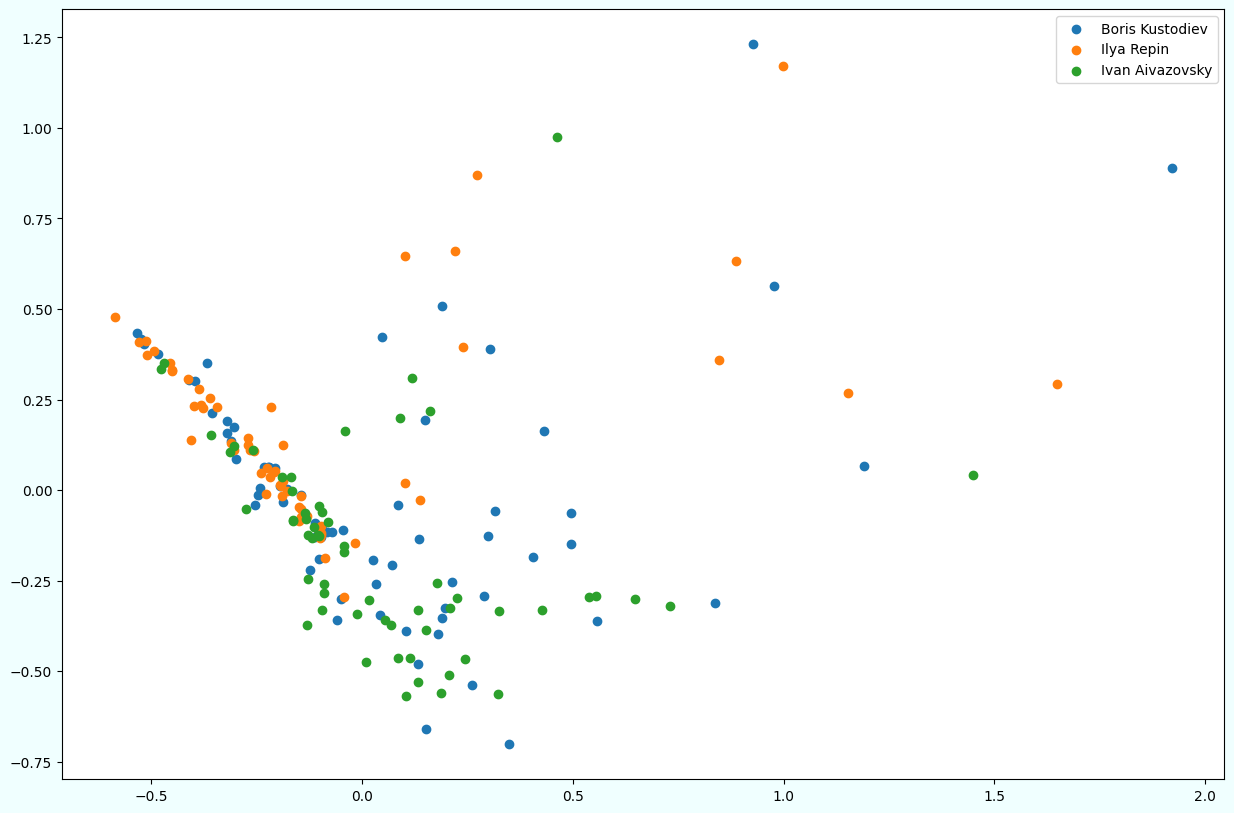

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_results)
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = principalComponents[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

## Training XGBoost Model

In [16]:
tree = XGBClassifier(seed=2020)
tree.fit(train_results, labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2020,
              silent=None, subsample=1, verbosity=1)

(28000, 2)

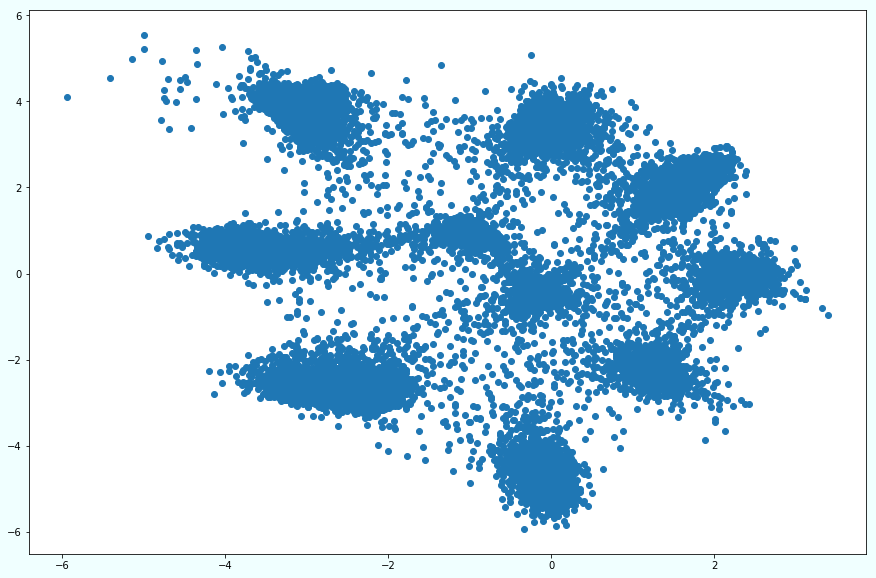

In [17]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for img in tqdm(test_loader):
        test_results.append(model(img.to(device)).cpu().numpy())
        
test_results = np.concatenate(test_results)

plt.figure(figsize=(15, 10), facecolor="azure")
plt.scatter(test_results[:, 0], test_results[:, 1], label=label)

test_results.shape

## Submit

In [18]:
submit = pd.read_csv("sample_submission.csv")
submit.Label = tree.predict(test_results)

submit.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,5
4,5,3


In [19]:
submit.to_csv("submission.csv", index=False)